# tsma 4: Clustering and phase diagram
All the examples are done with an implementation of Gross's model of 2022 : https://doi.org/10.1016/j.ecolecon.2010.03.021

This analysis is a homemade one, no articles are associated yet.

### requirements

In [1]:
from models.gross2022 import Gross2022 as model
from collect.output_management import query_nparameters, query_simulations

parameters = {
    "b_margin": 0.05,
    "hh_cons_propensity": 1,
    "norisk_interest": 0,
    "tgt_capital_ratio": 0.1,
    "smooth_interest": 15,
    "beta": 1, 
}

hyper_parameters = {"f_n": 200, "hh_n": 20000, "t_end": 100, "seed": 33}

initial_values = {
    "wages_0": 1,
    "wages_1": 1,
    "prices_0": 1.01,
    "prices_1": 1,
}

m = model(parameters, hyper_parameters, initial_values)
output = m.simulate(t_end = 40, seed = 10, save = True, overwrite = False)
varnames = list(output)
nvar = len(varnames)

## 1 Definition of:

- The variable selections **v**
- The embeddings **e**
- The metrics **m**

### The variable selections

Here certains set of variables are selected for the clustering. Indeed one can take only
flow variables for the stability of the metric computation for instance. More over PCA
can be used to reduce the dimensionality to limit the dimensionality curse

In [2]:
low_valued_vars = [
    16,  # unemployment_rate
    17,  # n_active
    19,  # rollover
    20,  # full_debt_service
    48,  # real_GDP_growth
    47,  # real_wage
    1,  # wage_inflation
    3,  # inflation
    30,  # mean_inflation
    31,  # mean_wage_inflation
    14,  # sPD
    15,  # sLGD
    8,  # interest
    23,  # Debt_to_GDP
    26,  # f_profit_share_GDP
    27,  # w_share_GDP
    29,  # firms_interest_coverage
    32,  # count_newloans
    33,  # count_topups
    10,  # capital_ratio
    42,  # mean_f_capr
]

dct_v = {
    "v1": low_valued_vars,  # flow variables with low values
    "v2": low_valued_vars + [34, 40],  # with mean_demand and mean_loan
}

# all variables
dct_v["v3"] = dct_v["v2"] + list(
    set(range(len(varnames))) - set(dct_v["v2"])
)

### The embeddings

The embedding add information to considered during the clustering. For instance if
the metric is purely geometrical, which means that the speed of time has no influence on
the output, it can be useful to add time as a feature.\
Here the embedding are functions on the outputs.

**embedding_lead_lag** can be used for these purpose.

In [3]:
from analyses.clustering import embedding_lead_lag

dct_e = {
    "e1": lambda outputs : outputs,
    "e2": lambda outputs : embedding_lead_lag(outputs, nlag = 1), 
    "e3": lambda outputs : embedding_lead_lag(outputs, nlag = 2), 
}

### The metrics 

The metric defines what similar means for two time series. It can be the euclidean
distance for instance.\
They are objects from the Metric class. Here Dynamic time warping and signature metric are implemented.\
See analyses.metrics to create your own classes.

In [4]:
from analyses.metrics import Ts_Metric, Sig_Metric

dct_m = {
    "m1": Ts_Metric("m1", 'Dynamic Time Warping', mtype = "dtw", div_thrs = 1e9,  ndiv_thrs = 2),
    "m2": Sig_Metric('m2','Signature metric', depth = 2, plot_sign = True)
}

## 2 Clustering selection and arguments:

### selection for preprocessing 

In [5]:
dct_select = {
    "m1": {"v1": ["e1"], },
    "m2": {"v2": ["e3"], "v2": ["e1","e2"]},
}

### arguments for clustering 

To see what are the models implemented by default **get_list_models** can be used
 

In [9]:
from analyses.clustering import get_list_models
get_list_models(dct_m)

['MiniBatch_KMeans',
 'DBSCAN',
 'OPTICS',
 'TsKMeans',
 'MeanShift',
 'Ward',
 'BIRCH',
 'Gaussian_Mixture',
 'Affinity_Propagation',
 'KMeans',
 'Agglomerative_Clustering',
 'Spectral_Clustering']

Finally, the numbers of clusters, the algorithms, and the parameters are defined as following:

In [6]:
args_clust = {
    
    "lst_nclust" :  range(3,6),
    
    "lst_models": [
        "TsKMeans",
        "KMeans",
        "MiniBatch_KMeans",
        #"Affinity_Propagation",
        #"MeanShift",
        #"Spectral_Clustering",
        # "Ward",
        # "Agglomerative_Clustering",
        # "DBSCAN",
        # "OPTICS",
        # "BIRCH",
        "Gaussian_Mixture",
    ],
    
    # other parameters of clustering algorithms
    "n_neighbors": 3,
    "quantile": 0.3,
    "eps": 0.3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "damping": 0.75,
    "preference": -220,
    "covariance_type_gmm": "spherical",  #'diag', 'spherical'
    
}

## 3 Clustering computation

### Data importation

In [7]:
import numpy as np
from analyses.clustering import get_data_for_clustering

df_params0, outputs0, path_figures = get_data_for_clustering(m, varnames, nsim = 40, sim_id0 = 0, step = 2, t_end = 40)

print(np.shape(outputs0))
df_params0.head()

100%|██████████| 39/39 [00:01<00:00, 38.34it/s]


(40, 50, 40)


,sim_id,p1__b_margin,p1__hh_cons_propensity,p1__norisk_interest,p1__tgt_capital_ratio,p1__smooth_interest,p1__beta,p2__f_n,p2__hh_n,p2__t_end,p2__seed,p3__wages_0,p3__wages_1,p3__prices_0,p3__prices_1
S0,S0,0.050000,1.000000,0.0,0.100000,15.0,1.0,200.0,20000.0,40.0,10.0,1.000000,1.000000,1.010000,1.000000
S4,S4,0.050000,1.000000,0.0,0.100000,15.0,1.0,200.0,20000.0,40.0,2.0,1.000000,1.000000,1.010000,1.000000
S6,S6,0.050000,1.000000,0.0,0.100000,15.0,1.0,200.0,20000.0,40.0,4.0,1.000000,1.000000,1.010000,1.000000
S10,S10,0.831712,0.996392,0.0,1.989607,15.0,1.0,116.0,44376.0,40.0,2.0,14.801047,27.756276,19.917936,15.105474
S12,S12,0.831712,0.996392,0.0,1.989607,15.0,1.0,116.0,44376.0,40.0,4.0,14.801047,27.756276,19.917936,15.105474


### Preprocessing

In [10]:
import numpy as np
from analyses.clustering import add_preproc

varnames0 = np.array(varnames)

preprocessing = {}

# plot the signatures or not
dct_m["m2"].plot_sign = False

add_preproc(preprocessing, df_params0["sim_id"], varnames0, outputs0, dct_v, dct_e, dct_m, dct_select)

C:\Users\samud\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1550: RuntimeWarning:

overflow encountered in multiply

C:\Users\samud\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1550: RuntimeWarning:

overflow encountered in multiply

C:\Users\samud\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1550: RuntimeWarning:

overflow encountered in multiply



### computation

**m_to_algopara** is used to 

In [11]:
from analyses.clustering import add_clusters, set_clust_algo, m_to_algopara

clusterings = {}
add_clusters(clusterings, preprocessing, args_clust, "c0", dct_m, f_algo=set_clust_algo, f_para = m_to_algopara)

C:\Users\samud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\samud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=1

C:\Users\samud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\samud\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning:

KMeans is known to have a memory leak on Windows

### post processing

Based on the parameters exploration , certain variables doesn't change so a new dataframe **df_params** for the parameters is built. Moreover all the results are sumarized on **df_clusterings**. The first two dataframes are useful for the clustering preselection and the phase diagramme visualization. The last one **df_clusters** is used to characterize and compare the clusters and the clustering approaches (see tsma5).

In [12]:
from analyses.clustering import get_clustering_dfs

not_intesting_para = ['p1__norisk_interest', 'p1__smooth_interest','p1__beta',"p2__t_end"]

df_params, df_clusterings, df_clusters = get_clustering_dfs(preprocessing, clusterings, df_params0, drop_col = not_intesting_para)

100%|██████████| 21/21 [00:00<00:00, 1754.62it/s]


In [13]:
df_params.head()

,sim_id,b_margin,hh_cons_propensity,tgt_capital_ratio,f_n,hh_n,seed,wages_0,wages_1,prices_0,prices_1
sim_id,,,,,,,,,,,
S0,S0,0.050000,1.000000,0.100000,200.0,20000.0,10.0,1.000000,1.000000,1.010000,1.000000
S4,S4,0.050000,1.000000,0.100000,200.0,20000.0,2.0,1.000000,1.000000,1.010000,1.000000
S6,S6,0.050000,1.000000,0.100000,200.0,20000.0,4.0,1.000000,1.000000,1.010000,1.000000
S10,S10,0.831712,0.996392,1.989607,116.0,44376.0,2.0,14.801047,27.756276,19.917936,15.105474
S12,S12,0.831712,0.996392,1.989607,116.0,44376.0,4.0,14.801047,27.756276,19.917936,15.105474


In [14]:
df_clusterings.head()

,name,model,res,clust_time,nclusters,good_cluster
0,m1_v1_e1_k3_TsKMeans_c0,"TimeSeriesKMeans(max_iter=30, metric='dtw', n_...","[1, 1, 1, 2, 2, 0, 0, 1, 1, 2, 2, 0, 2, 0, 2, ...",1.650957,3,True
1,m2_v2_e1_k3_KMeans_c0,KMeans(n_clusters=3),"[0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...",1.284557,3,True
2,m2_v2_e1_k3_MiniBatch_KMeans_c0,MiniBatchKMeans(n_clusters=3),"[0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2, 1, 0, 1, 0, ...",0.724584,3,True
3,m2_v2_e1_k3_Gaussian_Mixture_c0,"GaussianMixture(covariance_type='spherical', n...","[2, 2, 2, 0, 0, 0, 0, 2, 2, 1, 1, 0, 0, 0, 0, ...",0.204452,3,True
4,m2_v2_e2_k3_KMeans_c0,KMeans(n_clusters=3),"[0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 1, 1, ...",1.300515,3,True


Let's save df_clusters for the comparison of clusters in tsma5

In [26]:
from collect.output_management import save_clusters, save_temp_outputs
save_clusters(m, df_clusters, name = "temp")
save_temp_outputs(m, outputs0, name = "temp")
df_clusters.head()

,m1_v1_e1_k3_TsKMeans_c0,m2_v2_e1_k3_KMeans_c0,m2_v2_e1_k3_MiniBatch_KMeans_c0,m2_v2_e1_k3_Gaussian_Mixture_c0,m2_v2_e2_k3_KMeans_c0,m2_v2_e2_k3_MiniBatch_KMeans_c0,m2_v2_e2_k3_Gaussian_Mixture_c0,m1_v1_e1_k4_TsKMeans_c0,m2_v2_e1_k4_KMeans_c0,m2_v2_e1_k4_MiniBatch_KMeans_c0,...,m2_v2_e2_k4_KMeans_c0,m2_v2_e2_k4_MiniBatch_KMeans_c0,m2_v2_e2_k4_Gaussian_Mixture_c0,m1_v1_e1_k5_TsKMeans_c0,m2_v2_e1_k5_KMeans_c0,m2_v2_e1_k5_MiniBatch_KMeans_c0,m2_v2_e1_k5_Gaussian_Mixture_c0,m2_v2_e2_k5_KMeans_c0,m2_v2_e2_k5_MiniBatch_KMeans_c0,m2_v2_e2_k5_Gaussian_Mixture_c0
sim_id,,,,,,,,,,,,,,,,,,,,,
S0,1.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,3.0,2.0,...,2.0,2.0,2.0,0.0,0.0,3.0,1.0,3.0,0.0,2.0
S4,1.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,3.0,2.0,...,2.0,2.0,2.0,0.0,0.0,3.0,1.0,3.0,0.0,2.0
S6,1.0,0.0,0.0,2.0,0.0,1.0,2.0,3.0,3.0,2.0,...,2.0,2.0,2.0,0.0,0.0,3.0,1.0,3.0,0.0,2.0
S10,2.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,...,3.0,0.0,3.0,0.0,2.0,4.0,0.0,4.0,4.0,3.0
S12,2.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,2.0,0.0,...,3.0,0.0,3.0,0.0,2.0,4.0,0.0,4.0,4.0,3.0


## 4 Clustering preselection

**preselection** is used to determine which clusters are the most relevant, based on computation time, silhouette score on the behaviour space, then the silhouette score on the parameters space.

**time_coef** give the importance of computation time in the calculation of the score 

In [18]:
from analyses.clustering import preselection
preselected = preselection(preprocessing, df_clusterings, df_params, time_coef = 0)
preselected

add_scores


100%|██████████| 21/21 [00:00<00:00, 56.60it/s]


,name,silhouette,tottime,myscore,silh_para,model
0,m1_v1_e1_k3_TsKMeans_c0,0.229500,1.660932,0.000000,-0.062147,"TimeSeriesKMeans(max_iter=30, metric='dtw', n_..."
7,m1_v1_e1_k4_TsKMeans_c0,0.233678,0.558083,0.025463,-0.102283,"TimeSeriesKMeans(max_iter=30, metric='dtw', n_..."
1,m2_v2_e1_k3_KMeans_c0,0.383403,1.296524,0.937913,0.002395,KMeans(n_clusters=3)
17,m2_v2_e1_k5_Gaussian_Mixture_c0,0.354452,0.208440,0.761484,-0.059209,"GaussianMixture(covariance_type='spherical', n..."


## 5 clustered parameters and best projections

To compute the phase diagram, a single approach has to be selected. The preselection can be used, but a characterization of the clusters is needed to choose something qualitatively relevant.

In [19]:
clust_code = preselected.loc[preselected["silh_para"] == max(preselected["silh_para"]), "name"].values[0]
clust_code

'm2_v2_e1_k3_KMeans_c0'

Then the clusters have to be added to the parameters dataframe with **get_clustered_params**

In [21]:
from analyses.clustering import get_clustered_params
df_params_clustered = get_clustered_params(df_params, clusterings, preprocessing, clust_code)

Also, the 2D projection with the best discrimations are selected with **get_best_vars_4_proj**

the best variables for projections of the parameters space are :
 ['b_margin', 'hh_cons_propensity', 'tgt_capital_ratio', 'cluster']


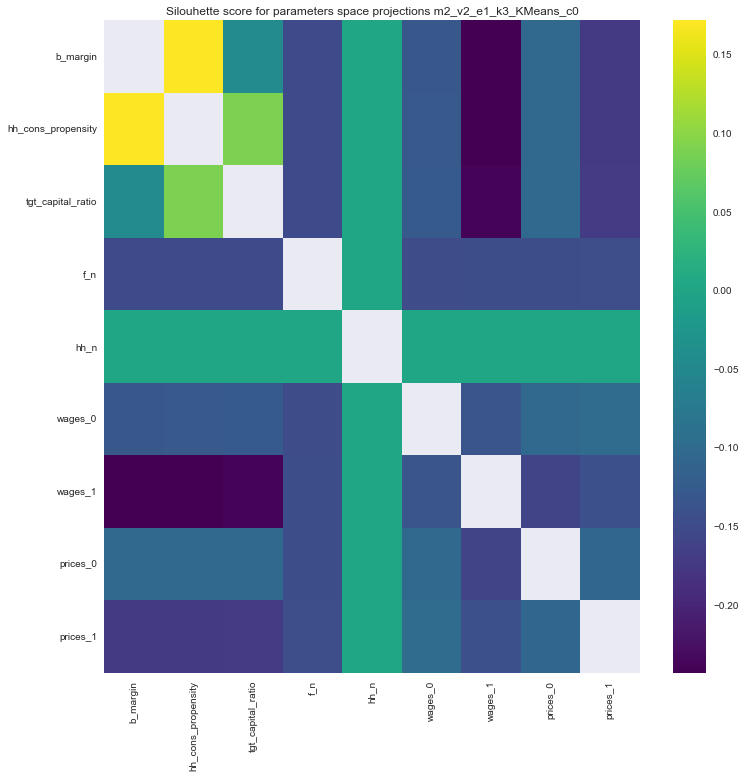

In [22]:
from analyses.clustering import get_best_vars_4_proj

df_score_proj, auto_lst_var = get_best_vars_4_proj(df_params_clustered, clusterings, 3, clust_code, heatmap = True, size = 12)

print(f"the best variables for projections of the parameters space are :\n {auto_lst_var[1:]}")

## 5 Phase Diagram

**phase_diag_pairplot** is finally used to create the phase diagram

C:\Users\samud\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

C:\Users\samud\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

C:\Users\samud\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

C:\Users\samud\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

C:\Users\samud\anaconda3\lib\site-packages\seaborn\axisgrid.py:1609: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.

C:\Users\samud\anaco

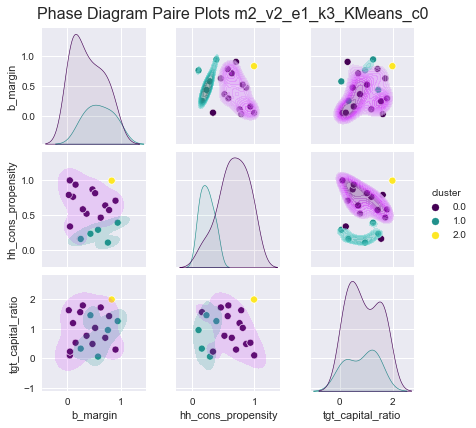

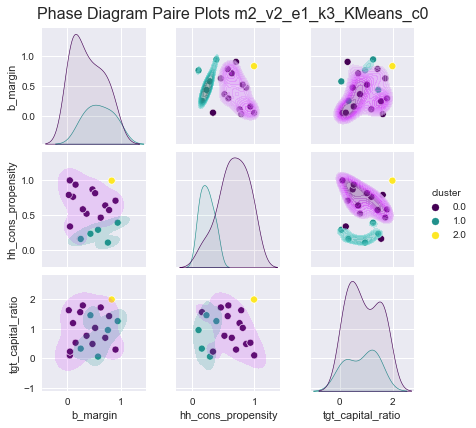

In [25]:
from visuals.figures import phase_diag_pairplot

phase_diag_pairplot(
    df_params_clustered.loc[:, auto_lst_var],
    clust_code,
    height=2,
    aspect=1,
    thr_low=0.2,
    thr_upp=0.5,
    alpha_low=0.2,
    alpha_upp=0.4,
    palette="viridis", #Spectral
)